In [1]:
from pynqOverlay import *
from pynqOverlayDriver import *
#viene richiamata la classe per la gestione del filtro e dell'hdmi
po = pynqOverlay()

hdmi_in = po.ol.video.hdmi_in
hdmi_out = po.ol.video.hdmi_out

In [ ]:
import PIL.Image
import numpy as np
from IPython.display import display
from pynq import allocate


#configurazione della modalità dei canali hdmi in RGB
hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode,PIXEL_RGB)


#start dei canali hdmiii
hdmi_in.start()
hdmi_out.start()
#collega il flusso da HDMI-in a HDMI-out
hdmi_in.tie(hdmi_out)


#cattura del frame 
frame = hdmi_in.readframe()

original_image = PIL.Image.fromarray(frame)
display(original_image)

In [17]:
#l'immagine viene convertita in scala di grigi per un filtraggio migliore

img=original_image.convert('L')
img.save("imagegray.png")

pic_width, pic_height = img.size
input_array = np.array(img)

In [18]:
#creazione dei buffer di input e output da passare al DMA tramite il filtro

image_buffer  =allocate(shape=(pic_height, pic_width), dtype=np.uint8, cacheable=True)
return_buffer =allocate(shape=(pic_height, pic_width), dtype=np.uint8, cacheable=True)

np.copyto(image_buffer,input_array)

In [19]:
import cv2

iterations = 100


for i in range(iterations):
    
#tramite questo ciclo vengono convertiti i frame in scala di grigi     
    
    inframe = hdmi_in.readframe()
    cv2.cvtColor(inframe,cv2.COLOR_RGB2GRAY,dst=image_buffer)
    inframe.freebuffer()

#si applica il filtro a ogni frame e restituito in output

    po.Sobel(image_buffer,-1,1,0,dst=return_buffer)  
    outframe = hdmi_out.newframe()
    cv2.cvtColor(return_buffer, cv2.COLOR_GRAY2RGB,dst=outframe)
    hdmi_out.writeframe(outframe)
               

FPS usando pynqOverlay con CMA:  10.338006879624853


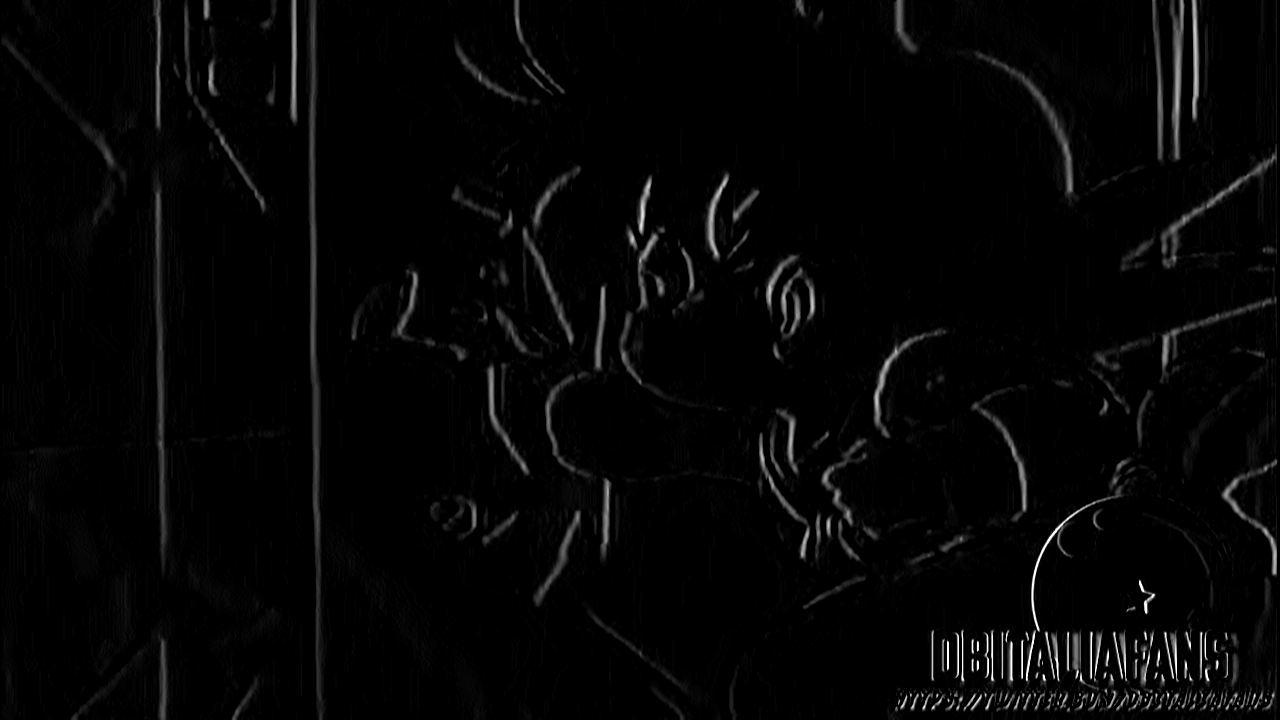

In [20]:
imgresult = PIL.Image.fromarray(return_buffer)
display(imgresult)

In [ ]:
#chiusura dei canali hdmi e dei buffer creati all'inizio del processo

hdmi_out.stop()
hdmi_in.stop()

del hdmi_in, hdmi_out

po.close()